In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
from torch.optim import Adam
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 100
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)
image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])
train_ds = datasets.CIFAR10(root='cifar_data',train=True,
                               download=True,transform=image_transforms)
val_ds = datasets.CIFAR10(root='cifar_data',train=False,
                                download=True,transform=image_transforms)
train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,shuffle=False)
classes = ["airplane",'automobile','bird','cat','deer',
          'dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


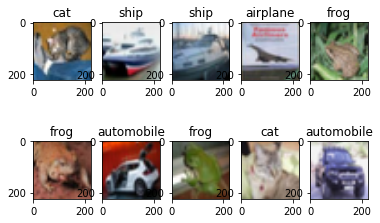

In [4]:
# View sample image
def image_decode(tensor):
    mean = np.array((0.5,0.5,0.5))
    std = np.array((0.5,0.5,0.5))
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image*np.array(std)+np.array(mean)
    image = image.clip(0,1)
    return image

def show_10_samples(samples,labels):
    fig,axes = plt.subplots(2,5)
    for row in range(2):
        for col in range(5):
            axis = axes[row,col]
            index = row*5+col
            axis.imshow(image_decode(samples[index]))
            axis.set_title(classes[labels[index].item()])
    plt.show()

temp_samples,temp_labels = next(iter(val_loader))
show_10_samples(temp_samples,temp_labels)

In [5]:
net = models.vgg16(pretrained=True)

In [6]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
for param in net.features.parameters():
  param.requires_grad = False

our_layer = nn.Linear(4096,10)
net.classifier[6] = our_layer
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(),lr=0.001)

In [ ]:
# train the network
epochs = 10
train_accuracies=[]
val_accuracies=[]
train_losses = []
val_losses = []
for epoch in range(epochs):
    t1 = time.time() 
    total_loss=0
    total_correct=0
    for index,(samples,labels) in enumerate(train_loader):
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = net.forward(samples)
        loss = criterion(outputs,labels)
        preds = torch.argmax(outputs,1)
        total_loss += loss
        total_correct += torch.sum(preds == labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if index % 50==49:
            print('.',end='')
    with torch.no_grad():
        val_loss=0
        val_correct=0
        for samples,labels in val_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net.forward(samples)
            loss = criterion(outputs,labels)
            preds = torch.argmax(outputs,1)
            val_loss += loss
            val_correct += torch.sum(preds==labels)
        print('\nEpoch:',epoch+1,
             'Training loss:',round(total_loss.item()*batch_size/len(train_ds),3),
             'Training accuracy:',round(total_correct.item()/len(train_ds),3),
             'Val loss:',round(val_loss.item()*batch_size/len(val_ds),3),
             'Val accuracy:',round(val_correct.item()/len(val_ds),3),
             'Time taken:',round(time.time()-t1))
        train_accuracies.append(round(total_correct.item()/len(train_ds),3))
        val_accuracies.append(round(val_correct.item()/len(val_ds),3))
        train_losses.append(round(total_loss.item()*batch_size/len(train_ds),3))
        val_losses.append(round(val_loss.item()*batch_size/len(val_ds),3))
print("Training losses:",train_losses)
print("Training accuracies:",train_accuracies)
print("Validation losses:",val_losses)
print("Validation accuracies:",val_accuracies)

..........
Epoch: 1 Training loss: 0.495 Training accuracy: 0.84 Val loss: 0.73 Val accuracy: 0.79 Time taken: 714
....


Epoch: 1 Training loss: 0.708 Training accuracy: 0.762 Val loss: 0.666 Val accuracy: 0.792 Time taken: 781
